# Training a network against a minimal dataset from the 1S shallow water surge equation

Training a Convolutional Neural Network (CNN) with data from the storm surge equation. See model_1d folder for the code that generated the data.

A simple setup for a surrogate model predicts the next time-step from the current one. This all starts from a mathematical model, which tyically involves Patial Differential Equations, but here we just collect the dynamic variables in the model in a vector $x$ at discrete times $t_0,t_1,\ldots,t_K$ and denote these as $x_k$. We can represent the numerical model as:

$x_{k+1}=M(x_k)$, starting with given initial condition $x_0$

Next, we run the numerical model and collect $x_0,x_1,\ldots,x_K$ as training data for our Machine Learning (ML) model. The aim of the ML model will be to approximate the numerical model, and we'll call it a surrogate model. It's main purpose is to have a faster but slightly less accurate version of the model. We denote the surrogate model as: 

$\hat{x}_{k+1}=\hat{M}(\hat{x}_k,\theta)$

starting with $\hat{x}_0=x_0$, which is the true initial condition.

This model has $\hat{x}_k$ as input and $x_{k+1}$ as output, and $\theta$ is a vector of parameters of the ML model to be estimated. For a given vector of parameters, one can sequentially compute $\hat{x}_1$, $\hat{x}_2$, $\hat{x}_3$, etc. This is called a rollout.

## Variables and boundary conditions in a CNN

In the mathematical notation of $x_k$ all variables are collected in a flattened vector, but for a Convolutional Neural Network that would not link nearby variables properly. Instead different variables are collected 
in a different array dimension called channels, so e.g. waterlevels $h$ and velocities $u$ are in different channels. Additional channels may be used for parameters like depth, and forcing like $\tau$.

## Training

For training the most basic approach is to use one-step-ahead predictions. This means that the target is to accurately approximate the output of the numerical model. We can write this as a loss function:

$J(\theta) = \sum_{k=1}^{K-1} | x_{k+1} - \hat{M}(x_k,\theta)|^2$

Viewed as a supervised learning method, we have the generated data $x_k$ as inputs and $x_{k+1}$ as outputs. As is common in such cases the input data are collected in an input array $X$ and an output array $Y$ that consist of:

$X=[x_0,x_1,\ldots,x_{K-1}]$
$Y=[x_1,x_2,\ldots,x_{K}]$ 

We can generalize $\hat{M}$ to matrices to obtain:

$Y \approx \hat{M}(X,\theta)$

Unfortunately there is no guarantee that reasonably accurate one-step-ahead predictions lead to accurate rollouts, since the errors can accumulate quickly.


## Important note about the default experiment in this notebook

The example in this notebook uses a very (too) small dataset. This cannot lead to good results and doesn't allow for good independence of the validation dataset. 
Because the example uses a model with few weights it still seems to work reasonably and trains in a few seconds on cpu. It is only meant to show the steps for
learning a CNN based model from the outputs of a 

In [1]:
# Initialize the Julia environment

# swithch to the directory where this script is located
cd(@__DIR__)
# Packages
using Pkg
Pkg.activate(".")

#Pkg.instantiate() # uncomment if you want to install the packages

# Load the required packages
using Flux
using BSON
using Plots, Measures
using JLD2
using ProgressMeter
using ComponentArrays

# optional gpu usage
const use_gpu = false
if use_gpu
    using cuDNN, CUDA
    CUDA.allowscalar(false) # disable scalar operations on GPU
    if CUDA.functional() # check if CUDA is functional
        println("CUDA is functional, using GPU")
    else
        error("CUDA is not functional, using CPU")
    end
end

  Activating project at `~/dellete/src/julia_ml_tests.jl.git/training_1d_flux`


In [ ]:
# Settings

# training
n_epochs = 2000
batch_size = 50
learning_rate = 0.001 # initial learning_rate
learning_rate_decay = 0.01 # lower learning rate at last eopch with factor
learning_rate_steps=500 # apply every n steps

decay_weight=1e-5

# data
input_file = joinpath("..", "model_1d", "wave1d_surge.jld2")
train_val_split = 0.8 # fraction of data used for training
# n_train = 250 # number of training samples, set to 1000 for faster training
# n_val = 100 # number of validation samples, set to 100 for faster training

# model
n_hidden = 16 # number of hidden features in the model
n_filter= 3 # width of the convolutional filter

nothing

In [3]:
# Load the data and convert it to input and output arrays

# check if the input file exists
if !isfile(input_file)
    println("Data file not found: $input_file")
end
println("Loading data from $input_file")
data=load(input_file)

# sizes
n_times=length(data["solution"])
n_steps=n_times-1 # number of time steps in the data
n_h_points=length(data["solution"][1].h)
n_u_points=length(data["solution"][1].u)

# channels
n_input_channels = 5 # h, u, D, tau, is_bound
input_channel_names = ["h", "u", "D", "tau","is_bound"]
n_output_channels = 2 # h, u
output_channel_names = ["h", "u"]
# Fixed in time parameters
D = data["params"].D # water depth
is_bound=zeros(size(D))
D[1]=1.0
D[end]=1.0

# Create inputs X and outputs Y
# Tensor shape: grid-points x channels x time-steps
X = zeros(Float32,n_u_points,n_input_channels,n_times-1) # Float32 for GPU compatibility, 1 channel since only one variable u
Y = zeros(Float32,n_u_points,n_output_channels,n_times-1) 
for t in 1:n_times-1 #copy data to the tensors
    # Fill inputs channel by channel 
    # was X[:,:,t] .= data["solution"][t]
    n=n_u_points
    X[1:n_h_points,1,t] .= data["solution"][t].h # h
    X[1:n,2,t] .= data["solution"][t].u # u
    X[1:n,3,t] .= D./30f0 # D
    X[1:n,4,t] .= data["solution"][t].tau # tau
    X[1:n,5,t] .= is_bound
    # Fill outputs channel by channel
    # was Y[:,:,t] .= data["solution"][t+1]
    Y[1:n_h_points,1,t] .= data["solution"][t+1].h # h
    Y[1:n,2,t] .= data["solution"][t+1].u # u
end

@show size(X)
@show size(Y)

# some metadata for plotting
output_times = data["times"][2:end]
output_x = data["grid"]

nothing

Loading data from ../model_1d/wave1d_surge.jld2
size(X) = (101, 5, 360)
size(Y) = (101, 2, 360)


In [4]:
# Split the data into training and validation sets

# determine number of training and validation samples
n_samples = size(X, 3)
n_train = Int(floor(train_val_split * n_samples))
n_val = n_samples - n_train
println("Number of samples: $(n_samples), training: $(n_train), validation: $(n_val)")

# Split the data into training and validation sets
X_train_cpu = X[:,:,1:n_train]
Y_train_cpu = Y[:,:,1:n_train]
X_val_cpu = X[:,:,n_train+1:n_train+n_val]
Y_val_cpu = Y[:,:,n_train+1:n_train+n_val]
@show size(X_train_cpu), size(Y_train_cpu)
@show size(X_val_cpu), size(Y_val_cpu)

Number of samples: 360, training: 288, validation: 72
(size(X_train_cpu), size(Y_train_cpu)) = ((101, 5, 288), (101, 2, 288))
(size(X_val_cpu), size(Y_val_cpu)) = ((101, 5, 72), (101, 2, 72))


((101, 5, 72), (101, 2, 72))

In [5]:
# move data to gpu or keep on cpu
if use_gpu
    X_train = gpu(X_train_cpu)
    Y_train = gpu(Y_train_cpu)
    X_val = gpu(X_val_cpu)
    Y_val = gpu(Y_val_cpu)
else
    X_train = X_train_cpu
    Y_train = Y_train_cpu
    X_val = X_val_cpu
    Y_val = Y_val_cpu
end

# create the data loaders
train_loader = Flux.DataLoader((X_train, Y_train), batchsize=min(batch_size,n_train), shuffle=true)

val_loader = Flux.DataLoader((X_val, Y_val), batchsize=min(batch_size,n_val), shuffle=false)

@show train_loader
@show val_loader
nothing

train_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, shuffle=true, batchsize=50)
val_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, batchsize=50)


In [ ]:
# Create the model

model_residual = Chain(
    Conv((n_filter,), n_input_channels=>n_hidden, swish; pad=1),
    Conv((n_filter,), n_hidden=>n_hidden, swish; pad=1),
    Conv((n_filter,), n_hidden=>n_hidden, swish; pad=1),
    Conv((n_filter,), n_hidden=>n_hidden, swish; pad=1),
    Conv((n_filter,), n_hidden=>n_output_channels, swish; pad=1)
)

# Define the model with residual block
struct ResidualBlock
    f::Chain
    n::Int32
end

# Define how the ResidualBlock works
function (m::ResidualBlock)(x) 
    skip = x[:,1:m.n,:] # skip connection on first m.n channels
    return skip + m.f(x)
end

# Allow Flux to recognize ResidualBlock as a layer
Flux.@layer ResidualBlock

# create the model with residual blocks
model_cpu = ResidualBlock(model_residual,2) # skip connection on first 2 channels

# Show the model strucure and number of parameters
@show model_cpu

# Move model to gpu or keep on cpu
if use_gpu
    model = gpu(model_cpu)
else
    model = model_cpu
end

model_cpu = ResidualBlock(Chain(Conv((3,), 5 => 16, swish, pad=1), Conv((3,), 16 => 16, swish, pad=1), Conv((3,), 16 => 16, swish, pad=1), Conv((3,), 16 => 2, swish, pad=1)), 2)


ResidualBlock(
  Chain(
    Conv((3,), 5 => 16, swish, pad=1),  # 256 parameters
    Conv((3,), 16 => 16, swish, pad=1),  # 784 parameters
    Conv((3,), 16 => 16, swish, pad=1),  # 784 parameters
    Conv((3,), 16 => 2, swish, pad=1),  # 98 parameters
  ),
  2,
)                   # Total: 8 arrays, 1_922 parameters, 8.117 KiB.

In [7]:
# Train the model

# Initialize the ADAM optimizer with default settings
opt=Adam(learning_rate)
#opt=OptimiserChain(WeightDecay(decay_weight), Adam(learning_rate)) # regularization with weight decay
opt_state = Flux.setup(opt,model)

# train loop
train_loss = Float32[]
val_loss = Float32[]
@showprogress for epoch in 1:n_epochs
    # Train the model on the training data
    # Loop over minibathches in the training data
    for (x_batch, y_batch) in train_loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x_batch) # apply the model to the input batch
            Flux.mse(y_hat, y_batch) # compute the loss
        end
        Flux.update!(opt_state, model, grads[1])
    end
    # evaluate over all training data and validation data
    # NOTE: we careless with compute, rerunning model each time below
    Y_train_hat = model(X_train)
    train_loss_epoch = Flux.mse(Y_train_hat, Y_train)
    push!(train_loss, train_loss_epoch)
    Y_val_hat = model(X_val)
    val_loss_epoch = Flux.mse(Y_val_hat, Y_val)
    push!(val_loss, val_loss_epoch)
    if epoch % learning_rate_steps == 0 # adjust learning rate
        println("Epoch $epoch: train loss $(train_loss_epoch), validation lost $(val_loss_epoch)")
        new_learning_rate = learning_rate * learning_rate_decay^(epoch/n_epochs)
        Flux.adjust!(opt_state, new_learning_rate)
    end
end


Progress:  17%|██████▊                                  |  ETA: 0:04:08

Epoch 500: train loss 3.0009235e-6, validation lost 1.7222208e-5


Progress:  33%|█████████████▋                           |  ETA: 0:02:53

Epoch 1000: train loss 7.544562e-7, validation lost 4.7734397e-6


Progress:  50%|████████████████████▌                    |  ETA: 0:02:04

Epoch 1500: train loss 4.3610416e-7, validation lost 2.6970117e-6


Progress:  67%|███████████████████████████▎             |  ETA: 0:01:21

Epoch 2000: train loss 3.2127835e-7, validation lost 2.2935212e-6


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:40

Epoch 2500: train loss 2.6250538e-7, validation lost 2.099709e-6


Progress: 100%|█████████████████████████████████████████| Time: 0:03:57


Epoch 3000: train loss 2.3646773e-7, validation lost 2.026418e-6


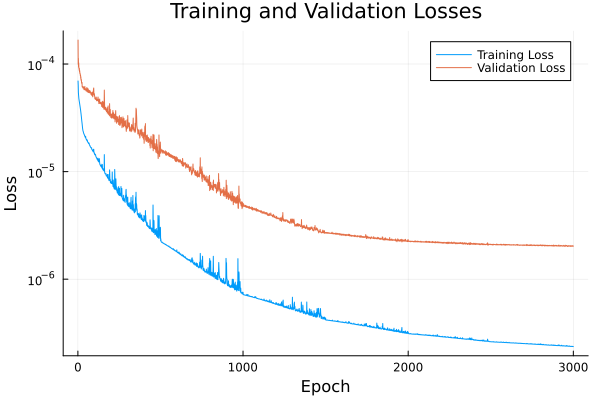

In [8]:
# Plot losses for training and validation
plot(train_loss, label="Training Loss", xlabel="Epoch", ylabel="Loss", title="Training and Validation Losses",yscale=:log10)
plot!(val_loss, label="Validation Loss", xlabel="Epoch",yscale=:log10)

In [9]:
# unroll the model to get the output for the initial condition
# using the X datastructure as input. 
# The size and function is similar to direct application of
# Y=f(X)
# but here the forecasted state is used for the next time-step.
# Other inputs are used. The state chanels are assumed to occupy the 
# channels 1:n_state_channels. 
# Since the size and content of the outputs is the same as when using 
# Y=model(X), the outputs can be used in the same manner. 
function unroll(model, X, n_state_channels)
    # compute first step
    y=model(X[:,:,1:1]) # First time-step uses the embedded state
    # collect sizes
    n_steps=size(X,3)
    (n_grid,n_output_channels,n_one_step)=size(y)
    # reserve space for outputs
    Y_unroll = zeros(Float32, n_grid,n_output_channels,n_steps)
    # save first step output
    Y_unroll[:,:,1]=y[:,:,1]
    for t in 1:n_steps
        # create input for next time-step
        x = X[:,:,t:t] # forcings. Overwrite state with y
        x[:,1:n_state_channels,1] .= y[:,1:n_state_channels,1]  # TEST slight damping to avoid instabilities
        # x[:,1:n_state_channels,1] .= 0.9999.*y[:,1:n_state_channels,1]  # TEST slight damping to avoid instabilities
        # model step
        y = model(x)
        # save output
        Y_unroll[:,:,t]=y[:,:,1]
    end
    return Y_unroll
end

# unroll the model to get the output for the initial condition
Y_unroll = unroll(model_cpu, X,2)

nothing

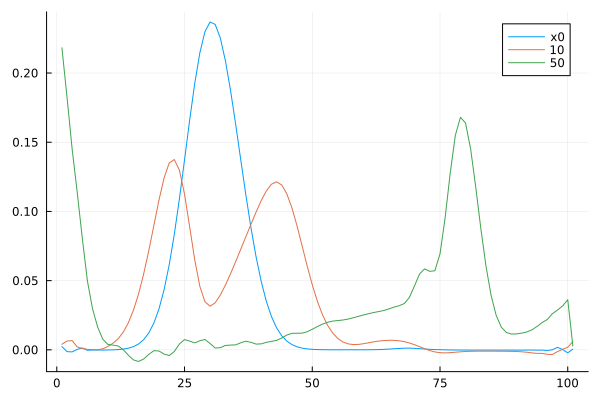

In [10]:
# plot some snapshots of the unrolled model output
plot(Y_unroll[:, 1, 1], label="x0")
plot!(Y_unroll[:,1,11], label="10")
plot!(Y_unroll[:,1,51], label="50")
#plot!(Y_unroll[:,1,101], label="100")
# plot!(Y_unroll[:,1,201], label="200")
# plot!(Y_unroll[:,1,301], label="300")

┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/training_1d_flux/wave1d_surge_ml_unroll.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/gYkEG/src/animation.jl:156


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/training_1d_flux/wave1d_surge_ml_unroll.gif")
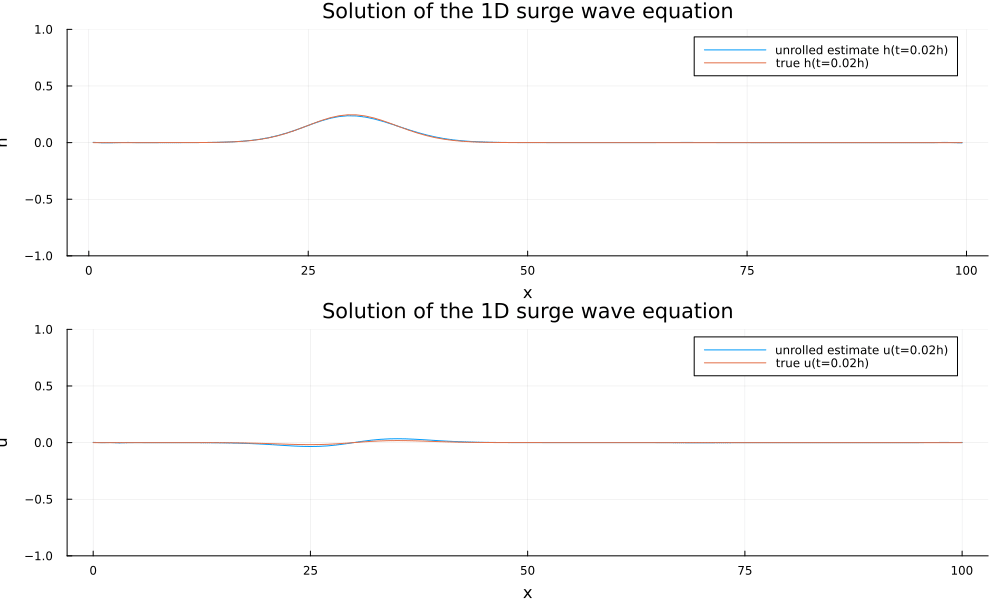

In [11]:
# Make movie of the unrolled output for wave model
function wave_movie(gif_filename,X,Y_unroll,output_times,output_x)
    # create a movie of the solution
    (n_grid_u,n_input_channels,n_steps)=size(X)
    n_grid_h=n_grid_u-1
    n_steps==length(output_times) || error("Length of output_time wrong.")
    anim = @animate for i in 1:n_steps
        # panel 1 plots h
        p1 = plot(0.001.*output_x.h, Y_unroll[1:n_grid_h,1,i], label="unrolled estimate h(t=$(round(output_times[i]/3600.0,digits=2))h)", xlabel="x", ylabel="h", ylim=(-1, 1))
        if i<n_steps
            plot!(p1,0.001.*output_x.h, X[1:n_grid_h,1,i+1], label="true h(t=$(round(output_times[i]/3600.0,digits=2))h)")
        end
        # panel 2 plots u
        p2 = plot(0.001.*output_x.u, Y_unroll[:,2,i], label="unrolled estimate u(t=$(round(output_times[i]/3600.0,digits=2))h)", xlabel="x", ylabel="u", ylim=(-1, 1))
        if i<n_steps
            plot!(p2,0.001.*output_x.u, X[:,2,i+1], label="true u(t=$(round(output_times[i]/3600.0,digits=2))h)")
        end
        # combine panels
        plot(p1, p2, layout=(2,1), size=(1000,600), title="Solution of the 1D surge wave equation")
    end
    return gif(anim, gif_filename, fps=15)
end

wave_movie("wave1d_surge_ml_unroll.gif",X,Y_unroll,output_times,output_x)